# Inversion of field MT data from the Coompana Province, South Australia
## MT site KN_1
### Data source: https://ecat.ga.gov.au/geonetwork/srv/eng/catalog.search#/metadata/112942

### Results report: https://ecat.ga.gov.au/geonetwork/srv/eng/catalog.search#/metadata/112981  (Figure 5)

## 0. Import modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import cofi
from espresso import Magnetotelluric1D
from espresso._magnetotelluric_1D import load_data

In [2]:
mt = Magnetotelluric1D()

#### 0.1 Load the data

In [3]:
filename = '16-A_KN2.dat'
freqs, dobs, derr = load_data(filename, error_floor = 0.05)

The data in the *16-A_KN2.dat*  file has been transformed from the original *16-A_KN2.edi*  file. 

The original file contains the information about the full impedance tensor $Z$ and its error. For the purpose of the 1D inversion presented here, we calculated beforehand the determinant of the complex impedance tensor, from which we then calculated the apparent resistivity, phase and their respective errors. 

#### 0.2 Set-up and plot the data

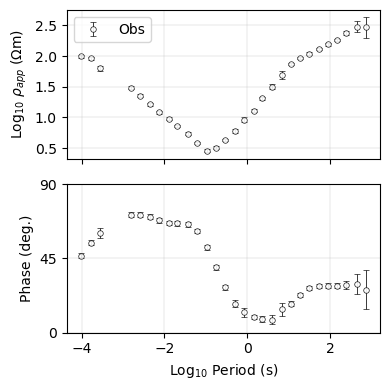

In [4]:
#set observed data
mt.set_obs_data(dobs, derr, freqs)
# plot the data
fig = mt.plot_data(mt.data, Cm = mt.covariance_matrix)

#### 0.3. Define a starting 1D mesh and model for the inversion

In [5]:
# the mesh contains many cells to produce a smooth model
nLayers, min_thickness, vertical_growth= 100, 3, 1.1
thicknesses = [min_thickness * vertical_growth**i for i in range(nLayers)]
starting_depths = np.cumsum(thicknesses)
starting_model = np.ones((len(starting_depths)+1)) * 2 # 100 ohm.m starting model (log10 scale) 
print('Model bottom: %.2f m'%starting_depths[-1])

Model bottom: 413388.37 m


#### 0.4. Set new starting model and mesh

In [6]:
mt.set_start_model(starting_model)
mt.set_start_mesh(starting_depths)

## 1. Define the problem

In [7]:
# define CoFI BaseProblem
mt_problem = cofi.BaseProblem()
mt_problem.set_initial_model(mt.starting_model)

In [8]:
# add regularization: smoothing
smoothing_factor = 50
reg_smoothing = cofi.utils.QuadraticReg(smoothing_factor, model_size = mt.model_size, reg_type = "smoothing")
reg = reg_smoothing

In [9]:
def objective_func(model, reg):
    dpred = mt.forward(model)
    data_misfit = mt.misfit(mt.data,dpred,mt.inverse_covariance_matrix)
    model_reg = reg(model)
    return  data_misfit + model_reg

In [10]:
mt_problem.set_objective(objective_func, args=[reg])

In [11]:
#mt_problem.summary()

## 2. Define the inversion options

In [12]:
#mt_problem.suggest_tools();

In [13]:
my_options = cofi.InversionOptions()
my_options.set_tool("scipy.optimize.minimize")
my_options.set_params(method="L-BFGS-B",options={'ftol':1e-3,'maxiter': 100})
#my_options.summary()

In [14]:
#my_options.suggest_solver_params()

## 3. Start an inversion

In [15]:
print("Running inversion...")
inv = cofi.Inversion(mt_problem, my_options)
inv_result = inv.run()
print("   done!")

Running inversion...
   done!


In [16]:
inv_result.summary()

Summary for inversion result
SUCCESS
----------------------------
fun: 45.669963089142534
jac: [-9.67553155e-02  4.38959094e-02  6.82454275e-01  1.07392851e-01
  8.37525254e-01 -1.21370648e-01 -5.63657213e-01  4.43481699e-01
  5.35197845e-01 -3.09576366e-02 -7.83715142e-01 -8.48954334e-01
 -4.82789628e-01 -1.51176280e+00 -1.50314961e+00 -6.25700381e-01
 -1.17063834e+00 -6.37830056e-01  4.33148273e-01 -6.99017733e-01
 -1.88972251e+00 -1.96317771e+00 -1.68295458e+00 -1.03896127e+00
 -5.81204060e-01 -5.44740428e-01 -8.50019438e-01 -7.47477462e-01
  8.31128948e-02 -1.14754784e-01 -3.38130948e-01  3.50532050e-02
 -1.00460867e+00 -7.61037460e-01  9.54664620e-01 -3.25651685e-01
 -1.28617544e+00  5.48804028e-01 -4.51701967e-01 -3.00628502e+00
 -1.29310607e+00  1.56568803e+00  1.04584217e+00 -7.91583692e-01
 -1.30446765e+00 -6.65543358e-01 -5.36445558e-02 -2.31671039e-01
 -6.14573285e-01 -4.24124383e-01 -1.10317445e-01 -1.49925939e-01
 -1.90193107e-01 -4.33445282e-02 -5.73479046e-03 -1.58849646

## 4. Plotting inversion results

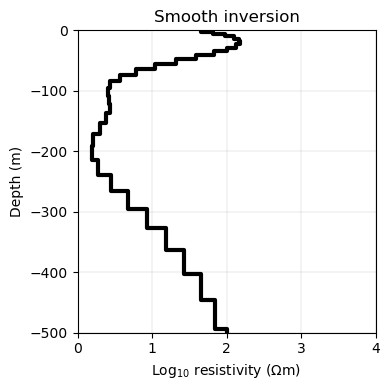

In [17]:
fig1 = mt.plot_model(inv_result.model, max_depth = -500, title='Smooth inversion');            # inverted model

nRMSE = 0.839


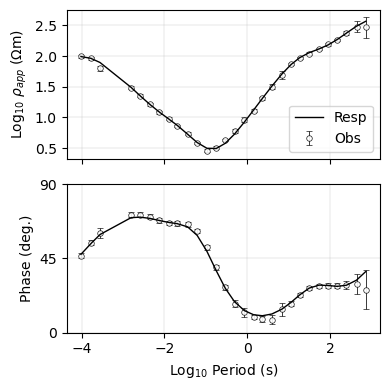

In [18]:
fig = mt.plot_data(mt.data, mt.forward(inv_result.model), Cm = mt.covariance_matrix)
nRMSE = np.sqrt(mt.misfit(mt.data, mt.forward(inv_result.model), Cm_inv = mt.inverse_covariance_matrix)/mt.data_size)
print('nRMSE = %.3f'%nRMSE)